In [1]:
import pandas as pd
import numpy as np
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("penguins_size.csv")
df = df.drop(["island","culmen_depth_mm","flipper_length_mm"],axis = 1)
df = df[df['species'] == 'Adelie']
df = df.drop(["species"],axis = 1)
df = df.dropna()
df['sex'] = df['sex'].replace({'FEMALE': 1, 'MALE': -1})
df['sex'] = df['sex'].astype(float)
X = df.iloc[:, :-1].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = df.iloc[:, -1].values  
Y = Y.reshape(-1, 1).astype(float) 
#Y[Y == 0] = -1 
X_and_Y = np.hstack((X, Y))     # Stack them together for shuffling.
np.random.seed(1)               # Set the random seed.
np.random.shuffle(X_and_Y)      # Shuffle the data points in X_and_Y array

/tmp/ipykernel_6487/3340130666.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['sex'].replace({'FEMALE': 1, 'MALE': -1})


In [3]:
def vis(X, Y, W=None, b=None):
    indices_neg1 = (Y == -1).nonzero()[0]
    indices_pos1 = (Y == 1).nonzero()[0]
    plt.scatter(X[:,0][indices_neg1], X[:,1][indices_neg1],
                c='blue', label='class -1')
    plt.scatter(X[:,0][indices_pos1], X[:,1][indices_pos1],
                c='red', label='class 1')
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')

    if W is not None:
        # w0x0+w1x1+b=0 => x1=-w0x0/w1-b/w1
        w0 = W[0]
        w1 = W[1]
        temp = -w1*np.array([X[:,1].min(), X[:,1].max()])/w0-b/w0
        x0_min = max(temp.min(), X[:,0].min())
        x0_max = min(temp.max(), X[:,1].max())
        x0 = np.linspace(x0_min,x0_max,100)
        x1 = -w0*x0/w1-b/w1
        plt.plot(x0,x1,color='black')

    plt.show()

# SVM
# 20 training

In [4]:
# Divide the data points into training set and test set.
X_shuffled = X_and_Y[:,:2]
Y_shuffled = X_and_Y[:,2]

split_index = int(0.2 * len(X_shuffled))  # 20% for training

X_train = X_shuffled[:split_index]
Y_train = Y_shuffled[:split_index]
X_test = X_shuffled[split_index:]
Y_test = Y_shuffled[split_index:]   
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(29, 2)
(29,)
(117, 2)
(117,)


C = 0.1
Decision boundary: -0.089x0+-0.719x1+0.077=0
Training error: 0.06896551724137934
Cross-validation score: 0.933




C = 1
Decision boundary: 0.252x0+-1.679x1+0.013=0
Training error: 0.06896551724137934
Cross-validation score: 0.933




C = 10
Decision boundary: 0.848x0+-3.013x1+-0.010=0
Training error: 0.06896551724137934
Cross-validation score: 0.933




C = 100
Decision boundary: 1.074x0+-3.546x1+-0.009=0
Training error: 0.06896551724137934
Cross-validation score: 0.933




C = 1000
Decision boundary: 1.101x0+-3.610x1+-0.009=0
Training error: 0.06896551724137934
Cross-validation score: 0.933




Best parameter C* = 0.1
Decision boundary: -0.089x0+-0.719x1+0.077=0


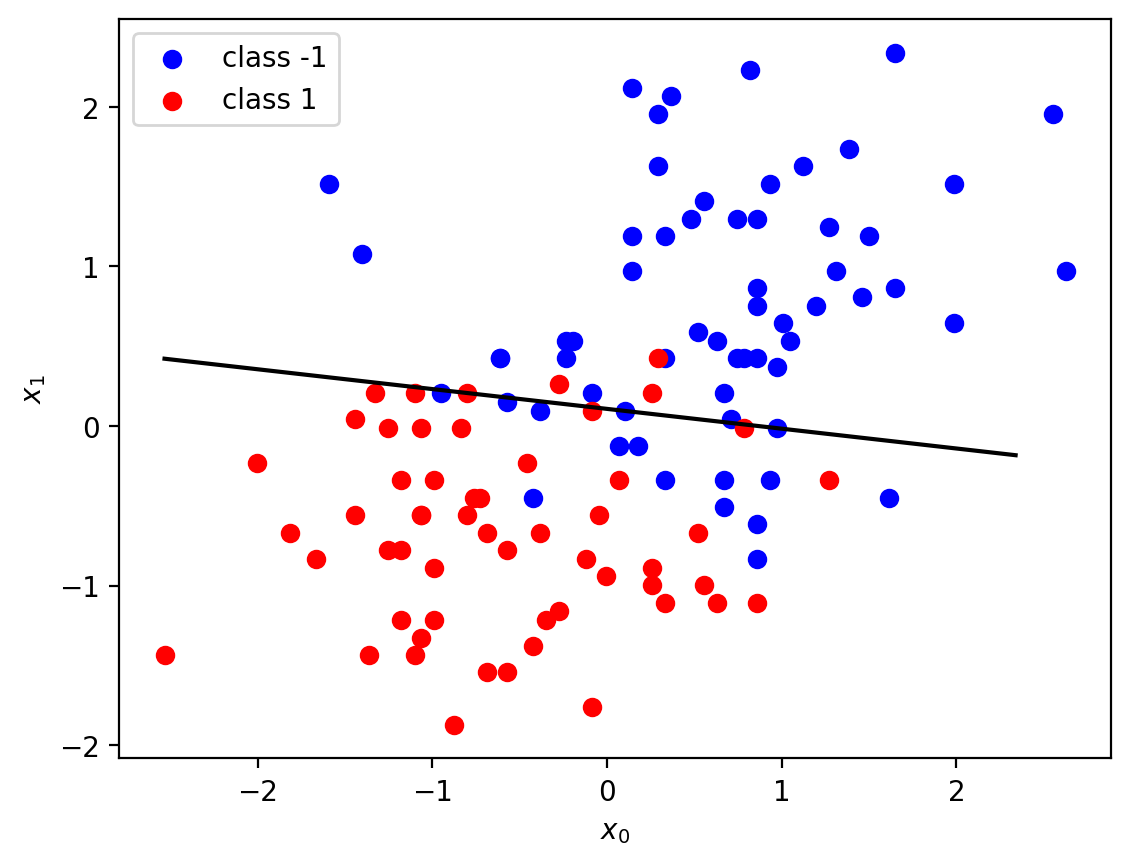

Test error: 0.1367521367521367
Train error: 0.06896551724137934


In [5]:
from sklearn.model_selection import cross_val_score

# Calculate error given feature vectors X and labels Y.
def calc_error(X, Y, classifier):
    # Hint: Use classifier.predict()
    Y_pred = classifier.predict(X)

    # Hint: Use accuracy_score().
    e = 1 - accuracy_score(Y, Y_pred)
    return e

C_list = [0.1, 1, 10, 100, 1000]
opt_e_train = 1.0   # Optimal training error.
opt_classifier = None  # Optimal classifier.
opt_C = None  # Optimal C.

for C in C_list:
    # Create a linear SVM classifier.
    # Hints: You can use svm.LinearSVC()
    #        Besides, we use Hinge loss and L2 penalty for weights.
    #        The max iterations should be set to 100000.
    #        The regularization parameter should be set as C.
    #        The other arguments of svm.LinearSVC() are set as default values.
    classifier = svm.LinearSVC(C=C, max_iter=100000, penalty='l2', dual=False)

    # Use the classifier to fit the training set (use X_train, Y_train).
    # Hint: You can use classifier.fit().
    classifier.fit(X_train, Y_train)

    # Obtain the weights and bias from the linear SVM classifier.
    W = classifier.coef_[0]
    b = classifier.intercept_[0]

    # Calculate cross-validation score.
    cv_score = cross_val_score(classifier, X_train, Y_train, cv=5).mean()

    # Show decision boundary, training error and test error.
    print('C = {}'.format(C))
    print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(W[0], W[1], b))
    e_train = calc_error(X_train, Y_train, classifier)
    print('Training error: {}'.format(e_train))
    print('Cross-validation score: {:.3f}'.format(cv_score))
    print('\n\n\n')

    # Judge if it is the optimal one.
    if e_train < opt_e_train:
        opt_e_train = e_train
        opt_classifier = classifier
        opt_C = C

opt_W = opt_classifier.coef_[0]
opt_b = opt_classifier.intercept_[0]
print('Best parameter C* = {}'.format(opt_C))
print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(opt_W[0], opt_W[1], opt_b))
vis(X_test, Y_test, opt_W, opt_b)
print('Test error: {}'.format(calc_error(X_test, Y_test, opt_classifier)))
print('Train error: {}'.format(calc_error(X_train, Y_train, opt_classifier)))


# 50 training

In [6]:
# Divide the data points into training set and test set.
X_shuffled = X_and_Y[:,:2]
Y_shuffled = X_and_Y[:,2]

split_index = int(0.5 * len(X_shuffled))

X_train = X_shuffled[:split_index]
Y_train = Y_shuffled[:split_index]
X_test = X_shuffled[split_index:]
Y_test = Y_shuffled[split_index:]   
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(73, 2)
(73,)
(73, 2)
(73,)


C = 0.1
Decision boundary: -0.496x0+-0.712x1+0.017=0
Training error: 0.12328767123287676
Cross-validation score: 0.877




C = 1
Decision boundary: -0.688x0+-1.047x1+0.000=0
Training error: 0.12328767123287676
Cross-validation score: 0.890




C = 10
Decision boundary: -0.763x0+-1.161x1+-0.012=0
Training error: 0.1095890410958904
Cross-validation score: 0.890




C = 100
Decision boundary: -0.775x0+-1.177x1+-0.014=0
Training error: 0.1095890410958904
Cross-validation score: 0.890




C = 1000
Decision boundary: -0.776x0+-1.179x1+-0.014=0
Training error: 0.1095890410958904
Cross-validation score: 0.890




Best parameter C* = 10
Decision boundary: -0.763x0+-1.161x1+-0.012=0


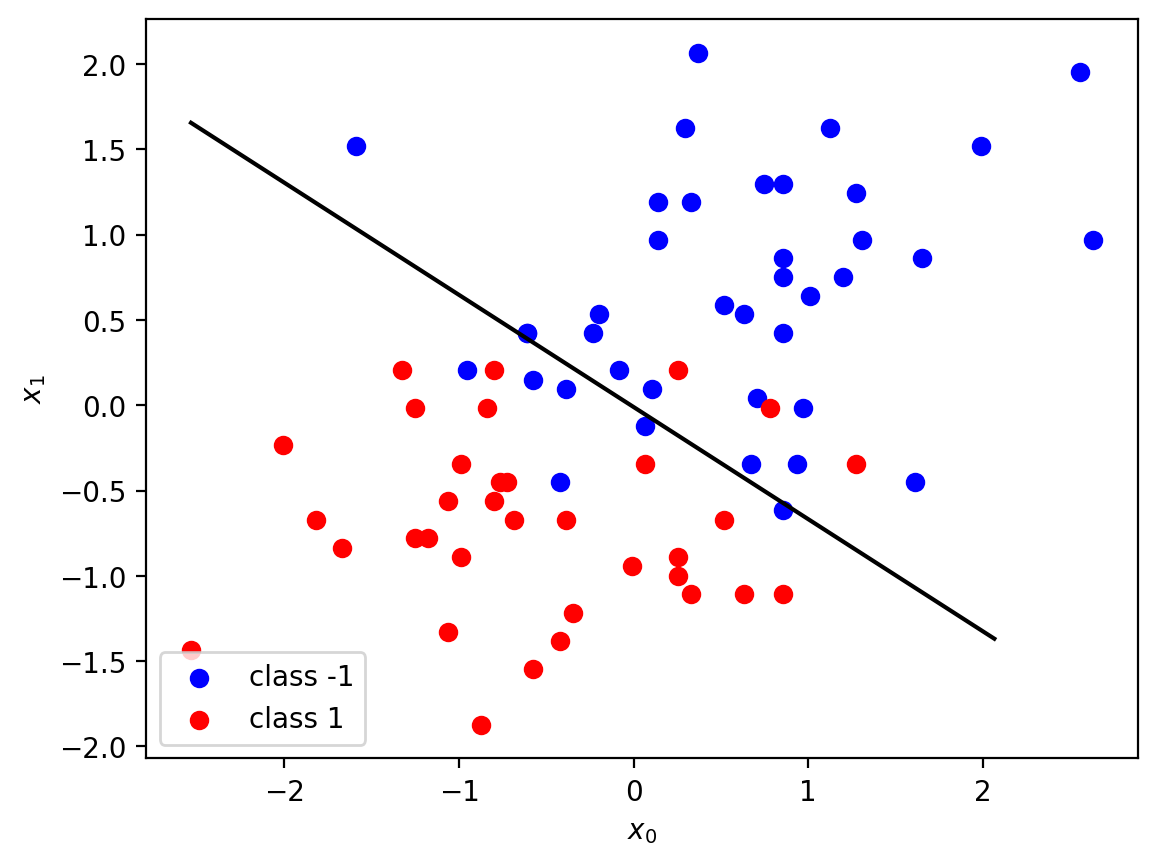

Test error: 0.12328767123287676
Train error: 0.1095890410958904


In [7]:
from sklearn.model_selection import cross_val_score

# Calculate error given feature vectors X and labels Y.
def calc_error(X, Y, classifier):
    # Hint: Use classifier.predict()
    Y_pred = classifier.predict(X)

    # Hint: Use accuracy_score().
    e = 1 - accuracy_score(Y, Y_pred)
    return e

C_list = [0.1, 1, 10, 100, 1000]
opt_e_train = 1.0   # Optimal training error.
opt_classifier = None  # Optimal classifier.
opt_C = None  # Optimal C.

for C in C_list:
    # Create a linear SVM classifier.
    # Hints: You can use svm.LinearSVC()
    #        Besides, we use Hinge loss and L2 penalty for weights.
    #        The max iterations should be set to 100000.
    #        The regularization parameter should be set as C.
    #        The other arguments of svm.LinearSVC() are set as default values.
    classifier = svm.LinearSVC(C=C, max_iter=100000, penalty='l2', dual=False)

    # Use the classifier to fit the training set (use X_train, Y_train).
    # Hint: You can use classifier.fit().
    classifier.fit(X_train, Y_train)

    # Obtain the weights and bias from the linear SVM classifier.
    W = classifier.coef_[0]
    b = classifier.intercept_[0]

    # Calculate cross-validation score.
    cv_score = cross_val_score(classifier, X_train, Y_train, cv=5).mean()

    # Show decision boundary, training error and test error.
    print('C = {}'.format(C))
    print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(W[0], W[1], b))
    e_train = calc_error(X_train, Y_train, classifier)
    print('Training error: {}'.format(e_train))
    print('Cross-validation score: {:.3f}'.format(cv_score))
    print('\n\n\n')

    # Judge if it is the optimal one.
    if e_train < opt_e_train:
        opt_e_train = e_train
        opt_classifier = classifier
        opt_C = C

opt_W = opt_classifier.coef_[0]
opt_b = opt_classifier.intercept_[0]
print('Best parameter C* = {}'.format(opt_C))
print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(opt_W[0], opt_W[1], opt_b))
vis(X_test, Y_test, opt_W, opt_b)
print('Test error: {}'.format(calc_error(X_test, Y_test, opt_classifier)))
print('Train error: {}'.format(calc_error(X_train, Y_train, opt_classifier)))


# 80 training

In [8]:
# Divide the data points into training set and test set.
X_shuffled = X_and_Y[:,:2]
Y_shuffled = X_and_Y[:,2]

split_index = int(0.8 * len(X_shuffled))

X_train = X_shuffled[:split_index]
Y_train = Y_shuffled[:split_index]
X_test = X_shuffled[split_index:]
Y_test = Y_shuffled[split_index:]   
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(116, 2)
(116,)
(30, 2)
(30,)


C = 0.1
Decision boundary: -0.457x0+-0.863x1+-0.061=0
Training error: 0.1293103448275862
Cross-validation score: 0.870




C = 1
Decision boundary: -0.572x0+-1.128x1+-0.103=0
Training error: 0.12068965517241381
Cross-validation score: 0.870




C = 10
Decision boundary: -0.600x0+-1.184x1+-0.114=0
Training error: 0.12068965517241381
Cross-validation score: 0.870




C = 100
Decision boundary: -0.604x0+-1.191x1+-0.115=0
Training error: 0.12068965517241381
Cross-validation score: 0.870




C = 1000
Decision boundary: -0.604x0+-1.191x1+-0.115=0
Training error: 0.12068965517241381
Cross-validation score: 0.870




Best parameter C* = 1
Decision boundary: -0.572x0+-1.128x1+-0.103=0


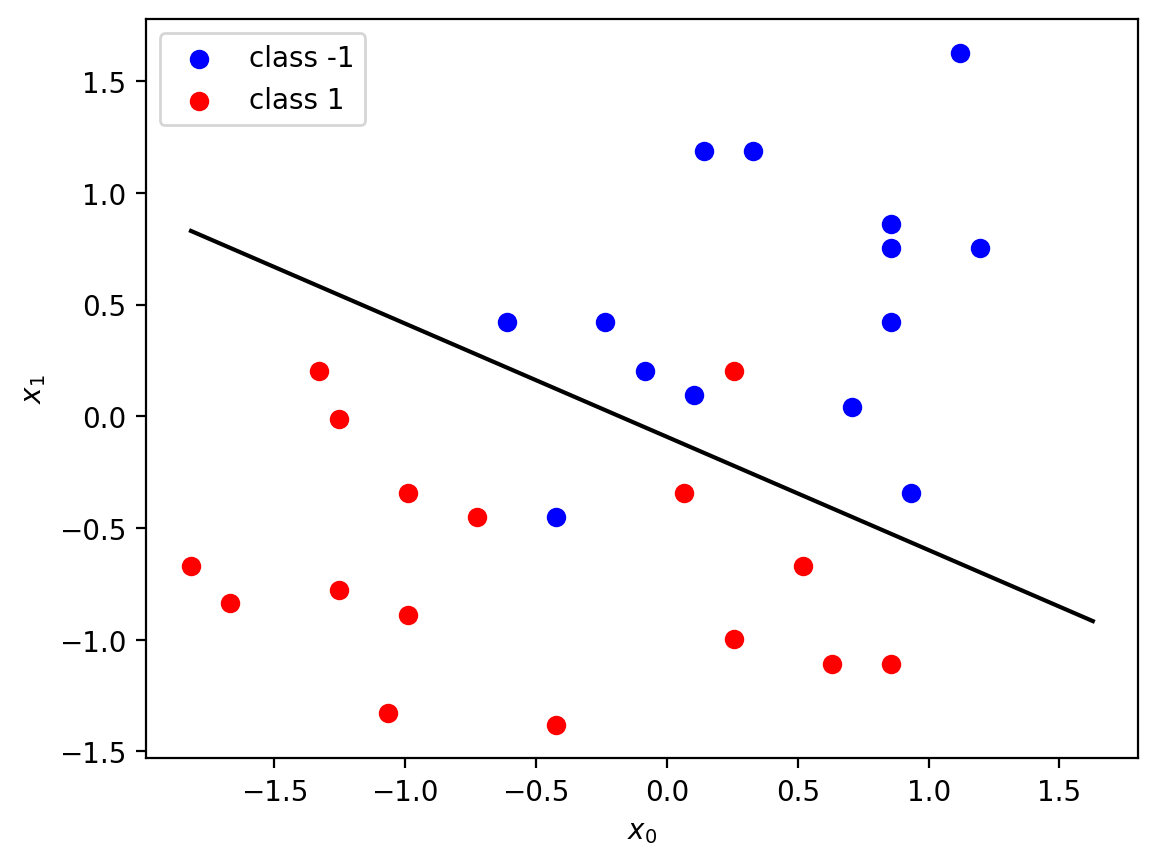

Test error: 0.06666666666666665
Train error: 0.12068965517241381


In [9]:
from sklearn.model_selection import cross_val_score

# Calculate error given feature vectors X and labels Y.
def calc_error(X, Y, classifier):
    # Hint: Use classifier.predict()
    Y_pred = classifier.predict(X)

    # Hint: Use accuracy_score().
    e = 1 - accuracy_score(Y, Y_pred)
    return e

C_list = [0.1, 1, 10, 100, 1000]
opt_e_train = 1.0   # Optimal training error.
opt_classifier = None  # Optimal classifier.
opt_C = None  # Optimal C.

for C in C_list:
    # Create a linear SVM classifier.
    # Hints: You can use svm.LinearSVC()
    #        Besides, we use Hinge loss and L2 penalty for weights.
    #        The max iterations should be set to 100000.
    #        The regularization parameter should be set as C.
    #        The other arguments of svm.LinearSVC() are set as default values.
    classifier = svm.LinearSVC(C=C, max_iter=100000, penalty='l2', dual=False)

    # Use the classifier to fit the training set (use X_train, Y_train).
    # Hint: You can use classifier.fit().
    classifier.fit(X_train, Y_train)

    # Obtain the weights and bias from the linear SVM classifier.
    W = classifier.coef_[0]
    b = classifier.intercept_[0]

    # Calculate cross-validation score.
    cv_score = cross_val_score(classifier, X_train, Y_train, cv=5).mean()

    # Show decision boundary, training error and test error.
    print('C = {}'.format(C))
    print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(W[0], W[1], b))
    e_train = calc_error(X_train, Y_train, classifier)
    print('Training error: {}'.format(e_train))
    print('Cross-validation score: {:.3f}'.format(cv_score))
    print('\n\n\n')

    # Judge if it is the optimal one.
    if e_train < opt_e_train:
        opt_e_train = e_train
        opt_classifier = classifier
        opt_C = C

opt_W = opt_classifier.coef_[0]
opt_b = opt_classifier.intercept_[0]
print('Best parameter C* = {}'.format(opt_C))
print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(opt_W[0], opt_W[1], opt_b))
vis(X_test, Y_test, opt_W, opt_b)
print('Test error: {}'.format(calc_error(X_test, Y_test, opt_classifier)))
print('Train error: {}'.format(calc_error(X_train, Y_train, opt_classifier)))
